In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance as gpd
import math

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
train_df = pd.read_csv('C:\\Users\\MH\\PycharmProjects\\Taxi Trip Duration\\data\\train.csv')
val_df = pd.read_csv('C:\\Users\\MH\\PycharmProjects\\Taxi Trip Duration\\data\\val.csv')

train_df_copy = train_df.copy()
val_df_copy = val_df.copy()

train_df_copy.head(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967
5,id2734699,2,2016-04-14 12:17:42,3,-73.969833,40.768570,-73.962646,40.767181,N,374
6,id2151697,2,2016-03-17 21:10:43,1,-73.988419,40.760006,-73.980530,40.782890,N,1252
7,id3635863,1,2016-02-05 06:43:21,1,-73.987854,40.749695,-73.985397,40.755932,N,148
8,id2169697,2,2016-03-22 14:08:02,1,-73.955017,40.764462,-73.996811,40.716560,N,1499
9,id2225613,1,2016-03-29 23:32:47,1,-73.971535,40.794827,-73.931709,40.858223,N,1017


In [3]:
def chk_data(df):
    print("SHAPE".center(70, '-'))
    print('Rows:{}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print(" Types ".center(70, '-'))
    print(df.dtypes)
    print("missing values".center(70, '-'))
    print(df.isnull().sum())
    print("Some statistical measures".center(70, '-'))
    print(df.describe())


chk_data(train_df_copy)

--------------------------------SHAPE---------------------------------
Rows:1000000
Columns: 10
------------------------------- Types --------------------------------
id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object
----------------------------missing values----------------------------
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
----------------------Some statistical measures-----------------------
            vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1000000.000000   1000000.000000    10000

* let's clean pickup and dropoff by city borders

In [4]:
x = ((train_df_copy['pickup_longitude'] <= -73.75) &
     (train_df_copy['pickup_longitude'] >= -74.03) &
     (train_df_copy['pickup_latitude'] <= 40.85) &
     (train_df_copy['pickup_latitude'] >= 40.63) &
     (train_df_copy['dropoff_longitude'] <= -73.75) &
     (train_df_copy['dropoff_longitude'] >= -74.03) &
     (train_df_copy['dropoff_latitude'] <= 40.85) &
     (train_df_copy['dropoff_latitude'] >= 40.63))
train_df_copy = train_df_copy[x]

* the trip duration minimum is 1s and maximum is 24 days, so will delete outliers by IQR

In [5]:
q1 = train_df_copy['trip_duration'].quantile(0.25)
q3 = train_df_copy['trip_duration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
train_df_copy['trip_duration'] = train_df_copy['trip_duration'].clip(lower=lower_bound, upper=upper_bound)

* check distribution of trip_duration

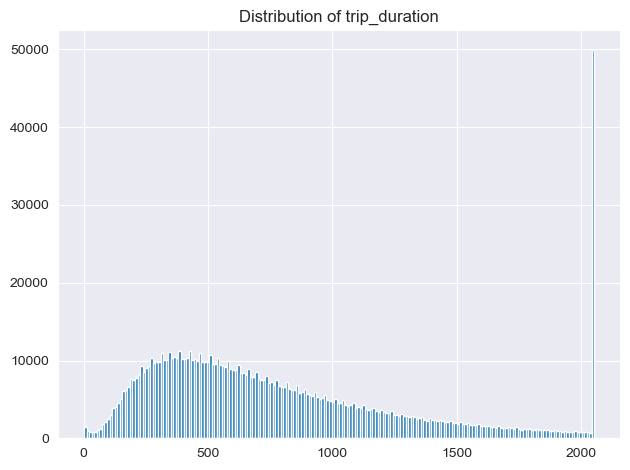

In [6]:
plt.hist(train_df_copy['trip_duration'], bins=200)
plt.title('Distribution of trip_duration')
plt.tight_layout()
plt.show()

* we need to transform distribution so we apply log on it

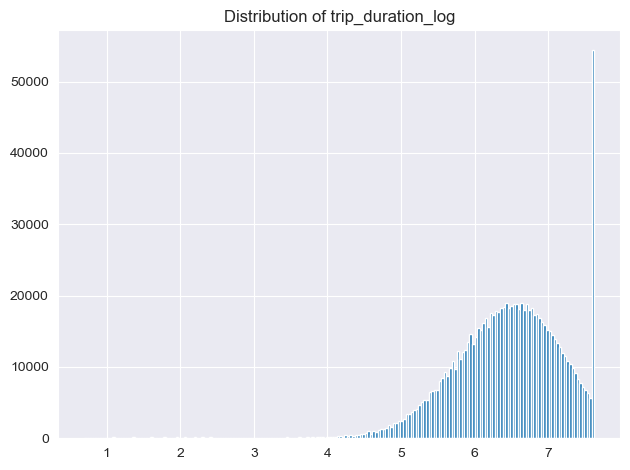

In [7]:
train_df_copy['trip_duration_log'] = np.log1p(train_df_copy['trip_duration'])
val_df_copy['trip_duration_log'] = np.log1p(val_df_copy['trip_duration'])

plt.hist(train_df_copy['trip_duration_log'], bins=200)
plt.title('Distribution of trip_duration_log')
plt.tight_layout()
plt.show()

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\4293758024.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df_copy['vendor_id'] , palette="crest_r")


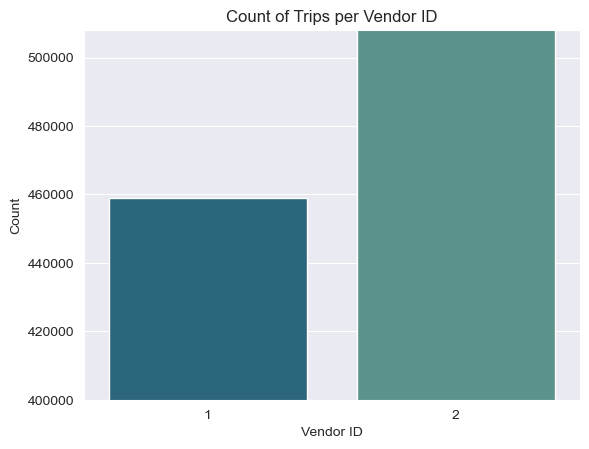

In [8]:
sns.countplot(x=train_df_copy['vendor_id'], palette="crest_r")
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.ylim(ymin=400000)
plt.ylim(ymax=508000)
plt.title('Count of Trips per Vendor ID')
plt.show()

* The vendor with ID 2 has 70,000 more trips compared to the vendor with ID 1

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\2924801293.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df_copy,x='vendor_id',y='trip_duration',palette='crest_r')


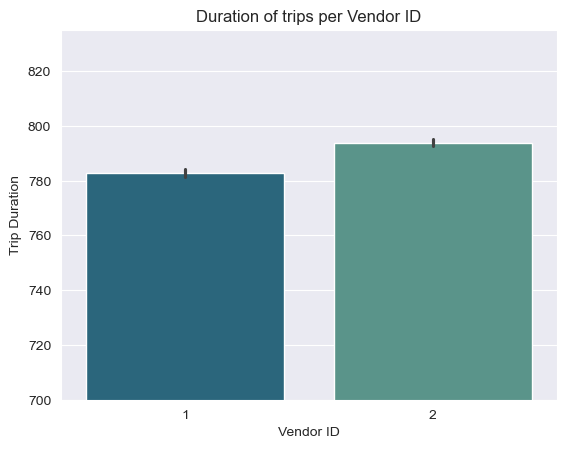

In [9]:
sns.barplot(data=train_df_copy, x='vendor_id', y='trip_duration', palette='crest_r')
plt.title('Duration of trips per Vendor ID')
plt.xlabel('Vendor ID')
plt.ylim(ymin=700)
plt.ylabel('Trip Duration')
plt.show()

* Vendor ID 2 has a difference of 20 in trip duration compared to Vendor ID 1 

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\2596411305.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df_copy['passenger_count'],palette='crest_r')


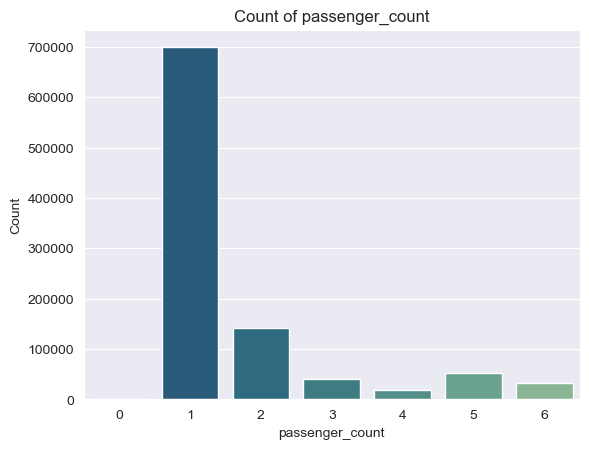

In [10]:
sns.countplot(x=train_df_copy['passenger_count'], palette='crest_r')
plt.xlabel('passenger_count')
plt.ylabel('Count')
plt.title('Count of passenger_count')
plt.show()

* Most taxis have 1 passenger per trip

## Makes new features

In [11]:
def features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['DayofMonth'] = df['pickup_datetime'].dt.day
    df['DayofWeek'] = df['pickup_datetime'].dt.dayofweek
    df['month'] = df['pickup_datetime'].dt.month
    df['hour'] = df['pickup_datetime'].dt.hour
    df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

    df['distance'] = df.apply(lambda row: calculate_distance(
        row['pickup_latitude'],
        row['pickup_longitude'],
        row['dropoff_latitude'],
        row['dropoff_longitude']
    ), axis=1)

    df['direction'] = df.apply(lambda row: calculate_bearing(
        row['pickup_latitude'],
        row['pickup_longitude'],
        row['dropoff_latitude'],
        row['dropoff_longitude']
    ), axis=1)

    df['rush_hour'] = df['hour'].apply(is_rush_hour)
    df['manhattan_distance'] = (abs(df['dropoff_longitude'] - df['pickup_longitude']) +
                                abs(df['dropoff_latitude'] - df['pickup_latitude']))


def calculate_distance(lat1, lon1, lat2, lon2):
    start = (lat1, lon1)
    end = (lat2, lon2)
    distance = gpd.geodesic(start, end).m
    return distance


def calculate_bearing(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


def is_rush_hour(hour):
    return 1 if (18 <= hour <= 22) else 0


features(train_df_copy)
features(val_df_copy)


In [12]:
train_df_copy.head(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_log,DayofMonth,DayofWeek,month,hour,dayofyear,distance,direction,rush_hour,manhattan_distance
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,6.947937,8,2,6,7,160,2759.701646,9.261031,0,0.029804
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,6.719013,3,6,4,12,94,1959.061795,-145.332373,0,0.027721
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,6.421622,5,6,6,2,157,1407.726725,70.081271,0,0.019981
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,6.766192,5,3,5,17,126,1976.073271,-2.289677,0,0.018719
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,2054,7.628031,12,3,5,17,133,20861.805081,-53.020809,0,0.310196
5,id2734699,2,2016-04-14 12:17:42,3,-73.969833,40.768570,-73.962646,40.767181,N,374,5.926926,14,3,4,12,105,626.072659,104.308804,0,0.008575
6,id2151697,2,2016-03-17 21:10:43,1,-73.988419,40.760006,-73.980530,40.782890,N,1252,7.133296,17,3,3,21,77,2627.121231,14.628871,1,0.030773
7,id3635863,1,2016-02-05 06:43:21,1,-73.987854,40.749695,-73.985397,40.755932,N,148,5.003946,5,4,2,6,36,723.020453,16.613246,0,0.008694
8,id2169697,2,2016-03-22 14:08:02,1,-73.955017,40.764462,-73.996811,40.716560,N,1499,7.313220,22,1,3,14,82,6384.136587,-146.518833,0,0.089695
10,id1421171,2,2016-06-13 22:40:11,6,-74.014519,40.714523,-73.978981,40.740440,N,958,6.865891,13,0,6,22,165,4158.932494,46.087817,1,0.061455


C:\Users\MH\AppData\Local\Temp\ipykernel_11372\4235546367.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DayofMonth', data=train_df_copy, palette="crest_r")


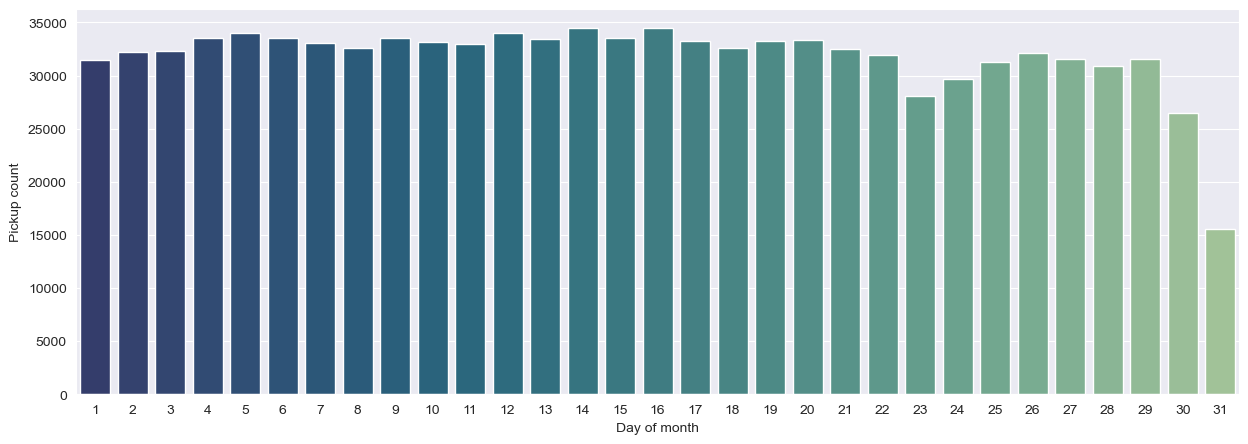

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(x='DayofMonth', data=train_df_copy, palette="crest_r")
plt.xlabel('Day of month')
plt.ylabel('Pickup count')
plt.show()

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\2726366308.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=train_df_copy, palette="crest_r")


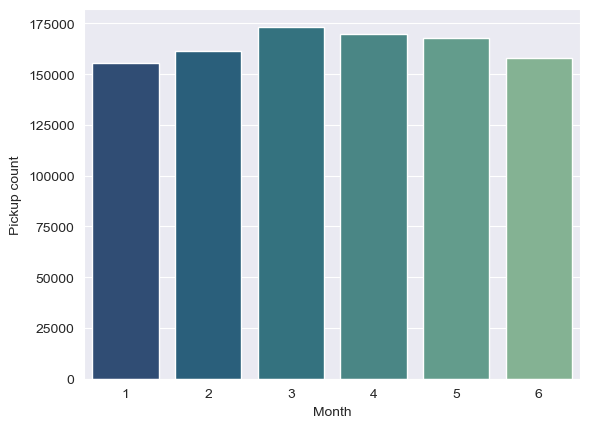

In [14]:
sns.countplot(x='month', data=train_df_copy, palette="crest_r")
plt.xlabel('Month')
plt.ylabel('Pickup count')
plt.show()

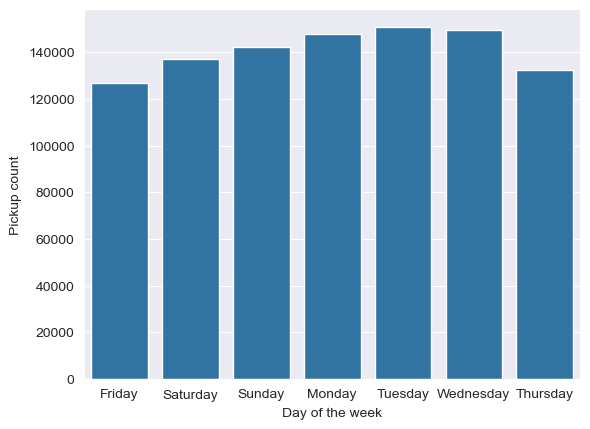

In [15]:
days = [i for i in range(7)]
sns.countplot(x='DayofWeek', data=train_df_copy)
plt.xlabel('Day of the week')
plt.ylabel('Pickup count')
plt.xticks(days, ('Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'))
plt.show()

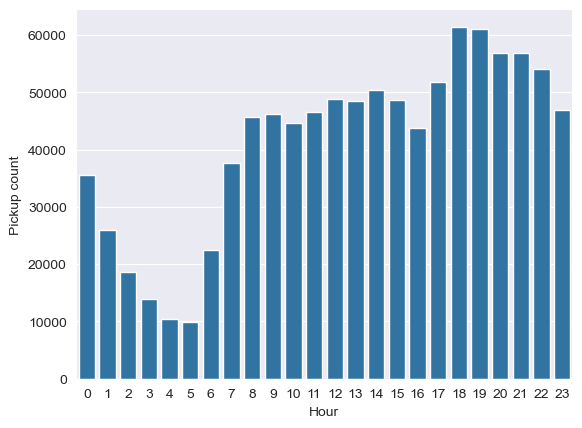

In [16]:
sns.countplot(x='hour', data=train_df_copy)
plt.xlabel('Hour')
plt.ylabel('Pickup count')
plt.show()

* the number of pickups gradually decreases after mid-night. The highest number of pickups are around 6pm and 7pm 

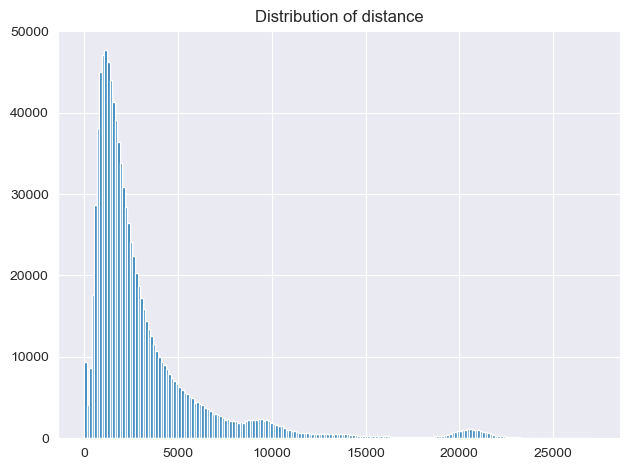

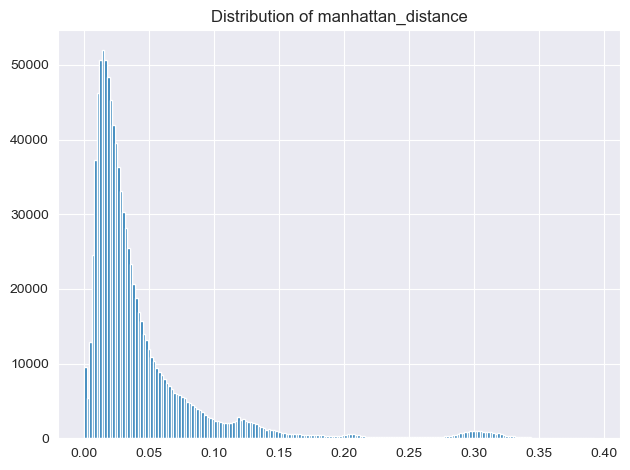

In [17]:
cols = ['distance', 'manhattan_distance']

for col in cols:
    plt.hist(train_df_copy[col], bins=200)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


* we use log to tansform distribution of data

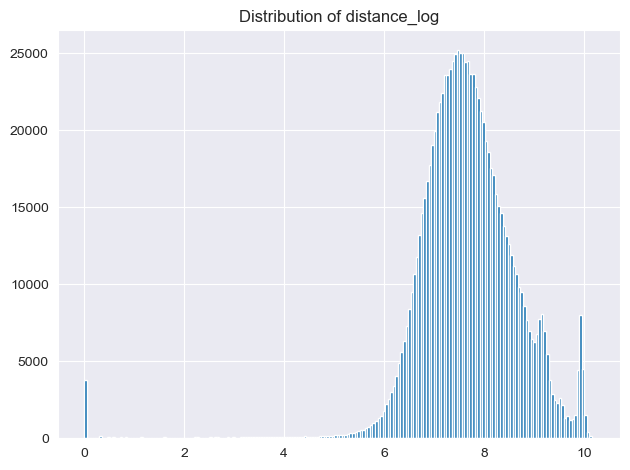

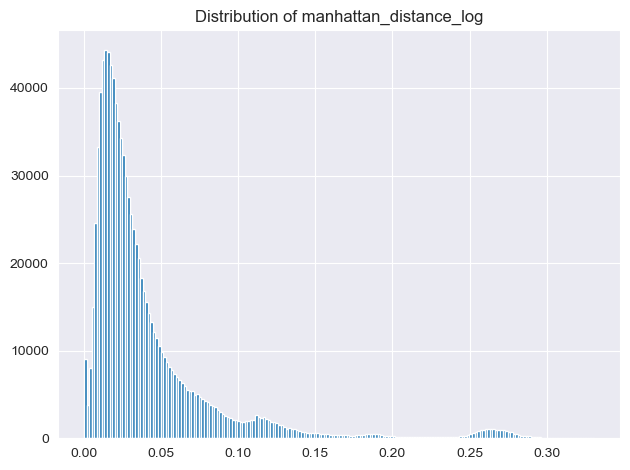

In [18]:
train_df_copy['distance_log'] = np.log1p(train_df_copy['distance'])
val_df_copy['distance_log'] = np.log1p(val_df_copy['distance'])
train_df_copy['manhattan_distance_log'] = np.log1p(train_df_copy['manhattan_distance'])
val_df_copy['manhattan_distance_log'] = np.log1p(val_df_copy['manhattan_distance'])

cols_log = ['distance_log', 'manhattan_distance_log']

for col in cols_log:
    plt.hist(train_df_copy[col], bins=200)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\2459870941.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df_copy, x=col, palette="crest_r")


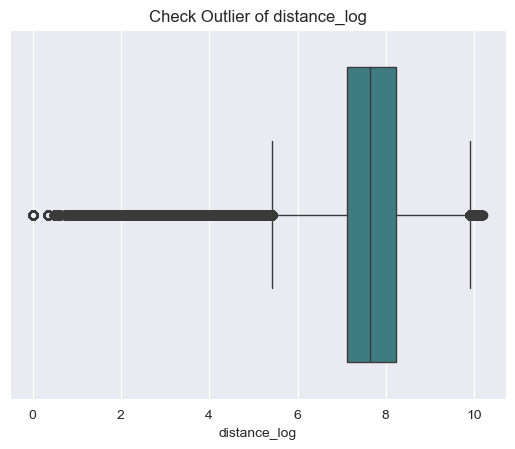

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\2459870941.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df_copy, x=col, palette="crest_r")


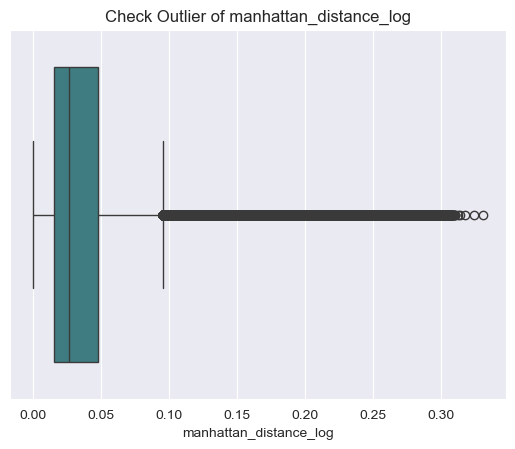

In [19]:
for col in cols_log:
    sns.boxplot(data=train_df_copy, x=col, palette="crest_r")
    plt.title(f'Check Outlier of {col}')
    plt.show()

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\392488785.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df_copy, x=col, palette="crest_r")


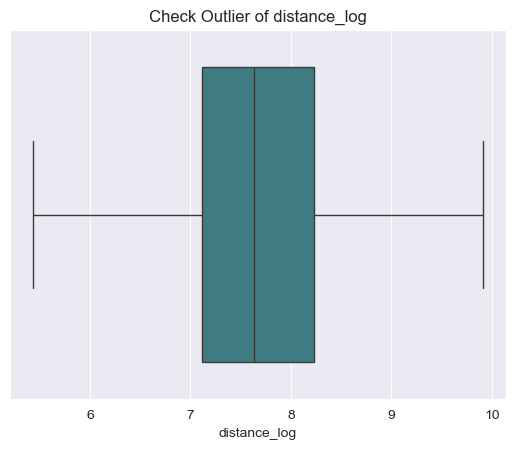

C:\Users\MH\AppData\Local\Temp\ipykernel_11372\392488785.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df_copy, x=col, palette="crest_r")


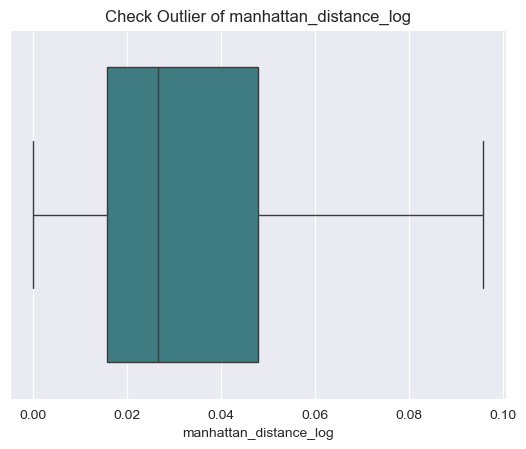

In [20]:
def remove_outliers(train_df_copy, col):
    q1 = train_df_copy[col].quantile(0.25)
    q3 = train_df_copy[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    train_df_copy[col] = train_df_copy[col].clip(lower=lower_bound, upper=upper_bound)


for col in cols_log:
    remove_outliers(train_df_copy, col)

for col in cols_log:
    sns.boxplot(data=train_df_copy, x=col, palette="crest_r")
    plt.title(f'Check Outlier of {col}')
    plt.show()

In [21]:
train_df_copy['direction_sin'] = np.sin(train_df_copy['direction'])
train_df_copy['direction_cos'] = np.cos(train_df_copy['direction'])
val_df_copy['direction_sin'] = np.sin(val_df_copy['direction'])
val_df_copy['direction_cos'] = np.cos(val_df_copy['direction'])

train_df_copy.drop(columns=['id', 'store_and_fwd_flag'], inplace=True)
val_df_copy.drop(columns=['id', 'store_and_fwd_flag'], inplace=True)

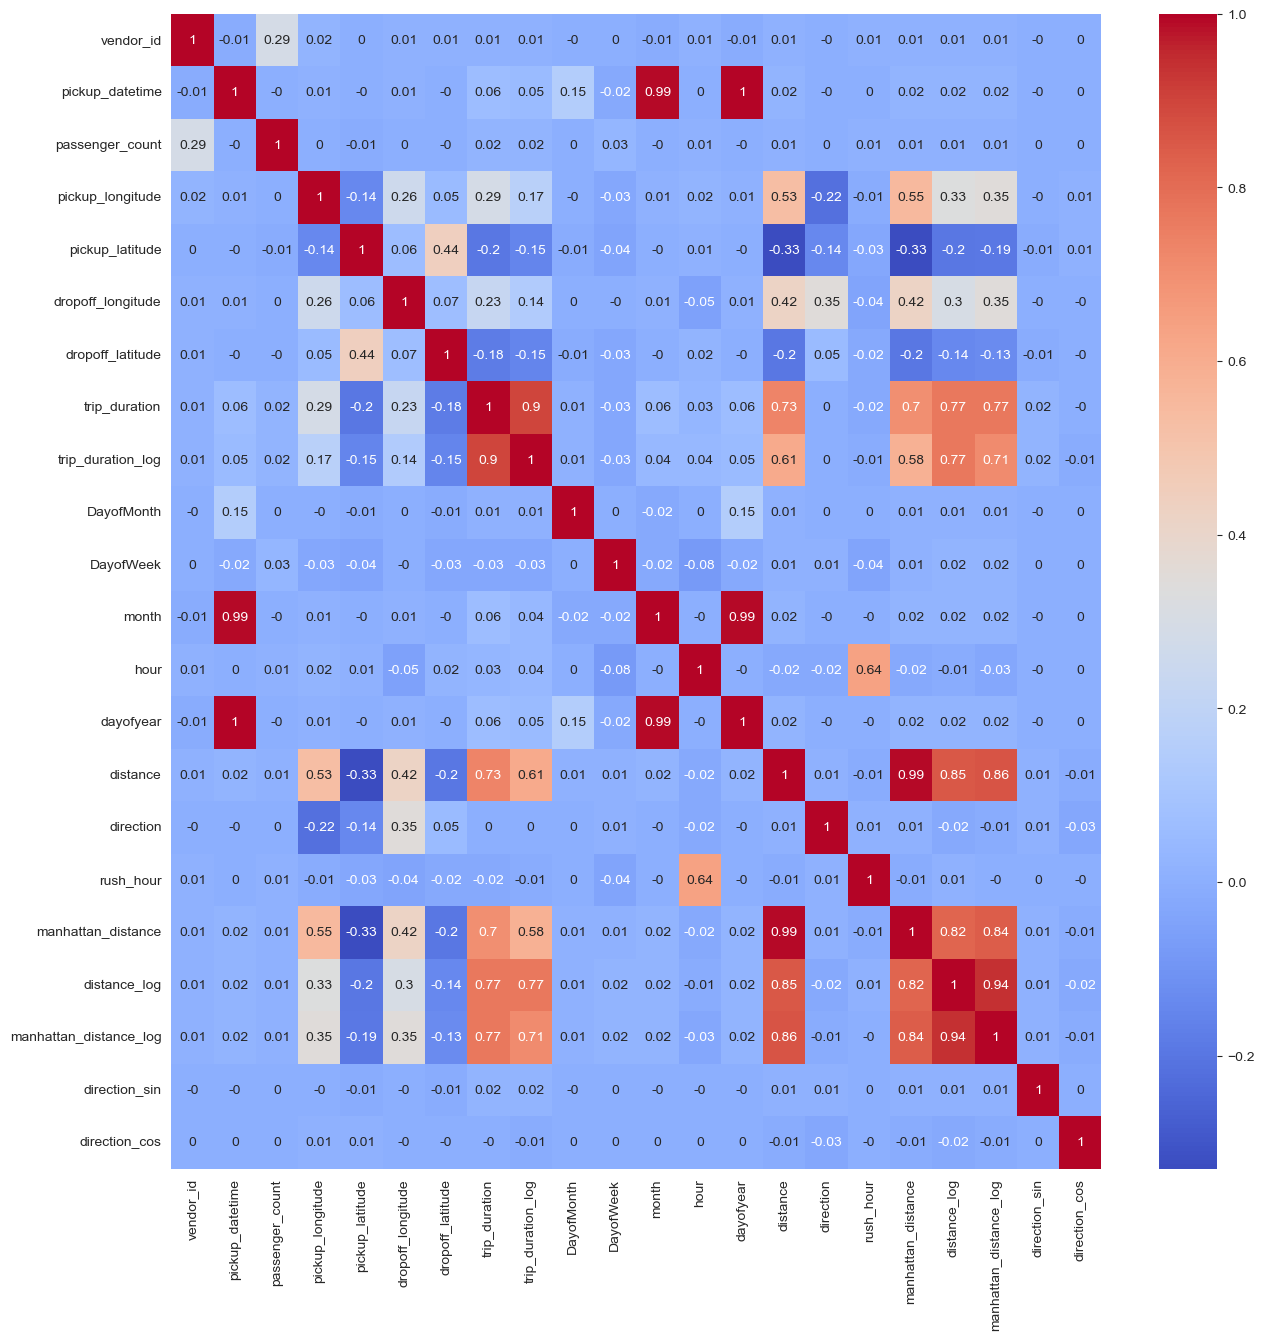

In [22]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_df_copy.corr().round(2), annot=True, cmap='coolwarm')
plt.show()

In [25]:
drop_cols = ['pickup_datetime', 'trip_duration', 'distance', 'direction', 'manhattan_distance']
train_df_copy = train_df_copy.drop(drop_cols, axis=1)
val_df_copy = val_df_copy.drop(drop_cols, axis=1)

train_df_copy.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_log,DayofMonth,DayofWeek,month,hour,dayofyear,rush_hour,distance_log,manhattan_distance_log,direction_sin,direction_cos
0,2,1,-73.985611,40.735943,-73.980331,40.760468,6.947937,8,2,6,7,160,0,7.923240,0.029369,0.163016,-0.986623
1,2,1,-73.978394,40.764351,-73.991623,40.749859,6.719013,3,6,4,12,94,0,7.580731,0.027344,-0.730539,0.682871
2,2,5,-73.989059,40.744389,-73.973381,40.748692,6.421622,5,6,6,2,157,0,7.250442,0.019784,0.822750,0.568403
3,2,2,-73.990326,40.731136,-73.991264,40.748917,6.766192,5,3,5,17,126,0,7.589373,0.018546,-0.752543,-0.658543
4,1,4,-73.789497,40.646675,-73.987137,40.759232,7.628031,12,3,5,17,133,0,9.915446,0.095778,-0.376732,-0.926322


In [26]:
train_df_copy.to_csv('C:\\Users\\MH\\PycharmProjects\\Taxi Trip Duration\\data\\train_df_prepared.csv',
                     index=False)
val_df_copy.to_csv('C:\\Users\\MH\\PycharmProjects\\Taxi Trip Duration\\data\\val_df_prepared.csv',
                     index=False)